In [1]:
!pip install emoji 
!pip install transformers
!pip install itranslate
!pip install wget
!pip install liwc

     |████████████████████████████████| 184 kB 4.2 MB/s 
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=cb5f274326d87451aff29ec607a7bda1fe92b2a65a0c0e7bd4022fbeb1d35b53
  Stored in directory: /root/.cache/pip/wheels/e4/61/e7/2fc1ac8f306848fc66c6c013ab511f0a39ef4b1825b11363b2
Successfully built emoji
     |████████████████████████████████| 2.6 MB 4.1 MB/s 
     |████████████████████████████████| 3.3 MB 47.5 MB/s 
     |████████████████████████████████| 636 kB 48.9 MB/s 
     |████████████████████████████████| 895 kB 51.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 76 kB 2.8 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 54 kB 3.4 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.w

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import transformers
from itranslate import itranslate as itrans
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import emoji
import nltk
from nltk.corpus import stopwords
import os
import wget
##Descarga de las stopwords por NLTK
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
##Función para quitar link, hashtags, emojis y caracteres especiales.
def clean_text(text):
    clean=text
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='username'))
    reg = re.compile('#[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='#'))
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='url'))
    reg = re.compile('[0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='0'))
    clean = clean.replace(r'[^\x00-\x7F]+', '', regex=True)
    return clean.apply(lambda x: ' '.join(re.sub("(#[A-Za-z0-9]+)|(/[A-Za-z0-9]+)|(@[A-Za-z0-9]+)|(www.[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|(/+:\/\/\S+)"," ",x).split()))


#Función para remover las stopwords
def byestop(text):
    nostop = text
    stop = stopwords.words('english')
    ##algo raro pasa que se tenía que pasar dos veces por el filtro para que se removieran las palabras, luego lo checo.
    nostop = text.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))
    return nostop.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stop))

#Función para tradicir textos
def trad(text):
    return text.apply(lambda x: itrans(x, to_lang="en"))

#Función para reducir la calidad y tamaño de las imagenes
def imgnorm(paths):
    images = paths.tolist()
    for image in images:
      img = cv2.imread(image)
      img = cv2.resize(img,(100,100))
      cv2.imwrite(image, img)
      img = cv2.resize(img,(400,400))
      cv2.imwrite(image, img)

#Función para obtener la lista de features de las imagenes
def to_image_features(path):
  print(path)
  hsv_list = []
  img = io.imread(path)
  img = color.rgb2hsv(img)
  hsv = []
  for i in range(len(img.shape)):
      if len(img.shape) == 2:
          imdata = img[:, i]
      elif len(img.shape) == 3:
          imdata = img[:, :, i]
      avg = np.mean(imdata)
      hsv.append(avg)
  hsv_list.append(hsv)
  print(np.mean(hsv_list, axis=0))
  return np.mean(hsv_list, axis=0)

In [4]:
##Cargamos el dataframe
df = pd.read_csv("instagram-posts.csv")
df

,image,caption,depression
0,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,⇒ follow me @yeasad for more edits 💜,1
1,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,😢😢😢😞....#cry #crying #cryingquotes #cryingquot...,1
2,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,NEVER! 🥀🥲Please like and save! 🥺Follow @deep_....,1
3,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,Ever 🥺❤️..If viewing follow @deepvibes_._ for ...,1
4,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,💞💞💞Follow @heartinntears for more quotes#brok...,1
...,...,...,...
1995,https://scontent-frx5-2.cdninstagram.com/v/t51...,#hijab #hijabhits #hijabers #hijabmurah #hijab...,0
1996,https://scontent-frt3-1.cdninstagram.com/v/t51...,100 Tagú Cigányzenekar Koncert#Vajdahunyadvar#...,0
1997,https://scontent-frt3-2.cdninstagram.com/v/t51...,Dag 109 med #positivevibes ♥️ Har lånt dette s...,0
1998,https://scontent-frx5-1.cdninstagram.com/v/t51...,Who else is excited about the weekend?🤗🤗🤗🤗Here...,0


In [5]:
#Limpiamos y traducimos los datos de las captions
df.caption = clean_text(df.caption)
df.caption = trad(df.caption)
df = df[df.caption.str.strip().str.len() != 0]
#df.to_csv("semipreproc.csv")

In [ ]:
df

,image,caption,depression
0,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,follow me username for more edits,1
2,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,NEVER Please like and save Follow username quo...,1
3,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,Ever If viewing follow username 0 for more,1
4,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,Follow username for more quotes,1
5,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,Sadness from today,1
...,...,...,...
1994,https://scontent-frt3-2.cdninstagram.com/v/t51...,SKN day The gym walk now HNG with riches,0
1996,https://scontent-frt3-1.cdninstagram.com/v/t51...,0 Tagu Ciganyzenkar concert,0
1997,https://scontent-frt3-2.cdninstagram.com/v/t51...,Day 0 With lnt this super beautiful text s thi...,0
1998,https://scontent-frx5-1.cdninstagram.com/v/t51...,Who else is excited about the weekend Here s u...,0


In [6]:
df.caption = byestop(df.caption)
#df.to_csv("semipreproc.csv")

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
#df = pd.read_csv('preproc.csv')
#Print number of observations and features
print('This dataset has {} observations with {} features.'.format(df.shape[0], df.shape[1]))
#Check for null values
df.info()

This dataset has 1717 observations with 3 features.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       1717 non-null   object
 1   caption     1717 non-null   object
 2   depression  1717 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.7+ KB


In [10]:
df

,image,caption,depression
0,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,follow username edits,1
2,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,never please like save follow username quotes0,1
3,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,ever viewing follow username 0,1
4,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,follow username quotes,1
5,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,sadness today,1
...,...,...,...
1994,https://scontent-frt3-2.cdninstagram.com/v/t51...,skn day gym walk hng riches,0
1996,https://scontent-frt3-1.cdninstagram.com/v/t51...,0 take cignyzenkar concert,0
1997,https://scontent-frt3-2.cdninstagram.com/v/t51...,day 0 lnt super beautiful text thinking day al...,0
1998,https://scontent-frx5-1.cdninstagram.com/v/t51...,else excited weekend us saying happy weekend e...,0


In [ ]:
#images = df.image.head(3).tolist()
#path = "/content/drive/MyDrive/csv/img"
#counter = 0
#for image in images:
   #save_as = os.path.join(path, "image" + str(counter) + '.jpg')
    #wget.download(image, save_as)
    #images[counter] = save_as
    #counter += 1

In [ ]:
#dfs = pd.DataFrame(images)
#dfs.columns = ['a']
#dfs

,a
0,/content/drive/MyDrive/csv/img/image0.jpg
1,/content/drive/MyDrive/csv/img/image1.jpg
2,/content/drive/MyDrive/csv/img/image2.jpg


In [8]:
import h5py
import os
import numpy as np
import pandas as pd
import liwc
from skimage import io, color
from typing import *
from collections import Counter
from pathlib import Path

In [11]:
df1 = df.dropna(subset=['image'])

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1717 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       1717 non-null   object
 1   caption     1717 non-null   object
 2   depression  1717 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 53.7+ KB


In [19]:
df = df[df.image != "https://instagram.fntr6-3.fna.fbcdn.net/v/t51.2885-15/e35/s1080x1080/227864994_509459046792846_1019007341449702603_n.jpg?_nc_ht=instagram.fntr6-3.fna.fbcdn.net&_nc_cat=106&_nc_ohc=B74zF2uKZNYAX9dvCWl&edm=AP_V10EBAAAA&ccb=7-4&oh=b120ac34b74744d950ef624900aaa38a&oe=610B8C30&_nc_sid=4f375e"]

In [20]:
#Obtener las features de las imagenes para luego concatenar al vector de embedding
df['image_features'] = df['image'].apply(to_image_features)
df.head()

https://instagram.fntr6-1.fna.fbcdn.net/v/t51.2885-15/e35/s1080x1080/225993802_363984615138396_5778460137618844813_n.jpg?_nc_ht=instagram.fntr6-1.fna.fbcdn.net&_nc_cat=100&_nc_ohc=0-0NFwLFA2wAX9NFJ_6&edm=AP_V10EBAAAA&ccb=7-4&oh=c97b8d947856b826318435c7d4caded8&oe=610BD765&_nc_sid=4f375e
[0.52009247 0.31945662 0.76381135]
https://instagram.fntr6-1.fna.fbcdn.net/v/t51.2885-15/e35/224875677_350368866762532_2887013502838392994_n.jpg?_nc_ht=instagram.fntr6-1.fna.fbcdn.net&_nc_cat=104&_nc_ohc=MQscP57rr4EAX9bpmgE&edm=AP_V10EBAAAA&ccb=7-4&oh=68d4a851b625df4c046b5f59a408369c&oe=610ACA20&_nc_sid=4f375e
[0.00467959 0.00115253 0.91548032]
https://instagram.fntr6-3.fna.fbcdn.net/v/t51.2885-15/e35/226736000_319331096552085_5338777607943476254_n.jpg?_nc_ht=instagram.fntr6-3.fna.fbcdn.net&_nc_cat=109&_nc_ohc=ho6gdpC-w4QAX_3PVQ-&edm=AP_V10EBAAAA&ccb=7-4&oh=135ba8fab8e58bf999533fda9cffa7a2&oe=610B4198&_nc_sid=4f375e
[0.80584544 0.37000498 0.46101536]
https://instagram.fntr6-3.fna.fbcdn.net/v/t51.2885-15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,image,caption,depression,image_features
0,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,follow username edits,1,"[0.5200924662030549, 0.3194566230166683, 0.763..."
2,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,never please like save follow username quotes0,1,"[0.0046795920522500044, 0.0011525310052612914,..."
3,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,ever viewing follow username 0,1,"[0.8058454401024163, 0.3700049847485245, 0.461..."
4,https://instagram.fntr6-3.fna.fbcdn.net/v/t51....,follow username quotes,1,"[0.32469689524045725, 0.21515140469338667, 0.4..."
5,https://instagram.fntr6-1.fna.fbcdn.net/v/t51....,sadness today,1,"[0.0031535660531931105, 0.0011082223823046073,..."


In [21]:
#Deshacerse de la columna de image
df.drop(["image"], axis=1, inplace=True)
df.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,caption,depression,image_features
0,follow username edits,1,"[0.5200924662030549, 0.3194566230166683, 0.763..."
2,never please like save follow username quotes0,1,"[0.0046795920522500044, 0.0011525310052612914,..."
3,ever viewing follow username 0,1,"[0.8058454401024163, 0.3700049847485245, 0.461..."
4,follow username quotes,1,"[0.32469689524045725, 0.21515140469338667, 0.4..."
5,sadness today,1,"[0.0031535660531931105, 0.0011082223823046073,..."


In [22]:
#Definir los posts de depresion y de no depresión
depression_posts = df[df['depression'] == 1]
positive_posts = df[df['depression'] == 0]


depression_posts = depression_posts.loc[np.random.choice(depression_posts.index, 10, replace=False)]
positive_posts = positive_posts.loc[np.random.choice(positive_posts.index, 10, replace=False)]

In [23]:
frames = [depression_posts, positive_posts]
df = pd.concat(frames)

In [24]:
#Obtener el set de training y test, y hacer un shuffle
from sklearn.model_selection import train_test_split

train, test  = train_test_split(df, test_size=0.2, random_state=42)

In [25]:
train.head()

,caption,depression,image_features
591,another life would girl,1,"[0.13061370761775143, 0.5079866259241856, 0.25..."
337,wish gay,1,"[0.6656057343053892, 0.3583457552523252, 0.409..."
1348,sold0 n long lake road alex meyers alexmeyersu...,0,"[0.49344326417643275, 0.405024418382856, 0.622..."
433,"hello, name mauricio urreariyu part wayuu comm...",1,"[0.2149271832303118, 0.25193044913116686, 0.61..."
1036,kicking real one birthday username username fr...,0,"[0.38204263361880486, 0.34940500740065256, 0.6..."


In [26]:
test.head()

,caption,depression,image_features
471,new album,1,"[0.5017926686563454, 0.28344948920646673, 0.52..."
1972,boy igr got hook family vrt nice little fadder...,0,"[0.0, 0.0, 0.7580381600333441]"
1645,lucky 0 whoot whoot 0 night sleep got username...,0,"[0.17806308794231782, 0.3595698792077346, 0.39..."
195,hits differentfollow username,1,"[0.46695811117807184, 0.18965493745852524, 0.2..."


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [28]:
tokenizer = Tokenizer()

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-07-31 20:49:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-31 20:49:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-31 20:49:09--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [30]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [31]:
train['caption'] = train['caption'].apply(str)
test['caption'] = test['caption'].apply(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
x_train = train.caption.to_numpy()
y_train= train.depression.to_numpy()
x_test= test.caption.to_numpy()
y_test= test.depression.to_numpy()


In [33]:
max_seq_len = 27
tokenizer = Tokenizer()

In [34]:
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index 
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size', vocab_size)

Vocabulary Size 202


In [35]:
X = tokenizer.texts_to_sequences(x_train)

In [36]:
X_train = pad_sequences(X,  maxlen=max_seq_len)
X = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(X,  maxlen=max_seq_len)

In [37]:
features_train = train.image_features.to_numpy()
features_train = np.stack(features_train)

In [38]:
type(features_train)

numpy.ndarray

In [39]:
type(X_train)

numpy.ndarray

In [40]:
features_train

array([[0.13061371, 0.50798663, 0.25557079],
       [0.66560573, 0.35834576, 0.40996711],
       [0.49344326, 0.40502442, 0.62216934],
       [0.21492718, 0.25193045, 0.61099349],
       [0.38204263, 0.34940501, 0.62202315],
       [0.15223349, 0.61874338, 0.64752726],
       [0.28275743, 0.2144784 , 0.71392117],
       [0.20673381, 0.82151988, 0.35202419],
       [0.25494501, 0.6906822 , 0.67151349],
       [0.59843361, 0.44502981, 0.59797897],
       [0.31411713, 0.35321066, 0.37057158],
       [0.15428191, 0.38804365, 0.4552575 ],
       [0.69775239, 0.65720891, 0.08273311],
       [0.18730832, 0.40918267, 0.56202545],
       [0.56697449, 0.16328288, 0.77058982],
       [0.3279643 , 0.12824114, 0.83420807]])

In [41]:
X_train.shape

(16, 27)

In [42]:
# Concaternar las features de la imagen con el embedding
X_train = np.concatenate((X_train, features_train), 1)

In [43]:
X_train.shape

(16, 30)

In [44]:
np.stack(features_train).shape

(16, 3)

In [45]:
features_test = test.image_features.to_numpy()
features_test = np.stack(features_test)

In [46]:
# Concaternar las features de la imagen con el embedding
X_test = np.concatenate((X_test, features_test), 1)

In [47]:
X_test.shape

(4, 30)

In [48]:
print(len(tokenizer.word_index))

201


In [49]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train.shape)
print(y_test.shape)

(16, 1)
(4, 1)


In [50]:
f = open("glove.6B.300d.txt", "r")

embedding_index = {}

for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_index[word] = coefs
f.close()

print('Found word vectors', len(embedding_index))

Found word vectors 400000


In [51]:
embedding_dim = 300

words = ['house', 'tiktok', 'dog']

for i in words:
  test = embedding_index.get(i)
  if test is not None:
    print(i)

house
dog


In [52]:

import tensorflow as tf

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                                           input_length=30, trainable=False)

# Modelo

In [72]:
import keras

In [78]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D, Bidirectional, LSTM, Input, Dropout, SpatialDropout1D, Dense

inp = Input(shape=(30,), dtype='int32')
embed_seq = embedding_layer(inp)

mod = SpatialDropout1D(0.1)(embed_seq)
mod = Bidirectional(LSTM(10, dropout=0.5, recurrent_dropout=0.5))(mod)
mod = Dropout(0.2)(mod)
output = Dense(1, activation='sigmoid')(mod)
model = keras.Model(inp, output)
model.summary()

The following Variables were used a Lambda layer's call (tf.compat.v1.nn.embedding_lookup_3), but
are not present in its tracked objects:
  <tf.Variable 'embedding/embeddings:0' shape=(202, 300) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
tf.compat.v1.nn.embedding_lo (None, 30, 300)           0         
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 30, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20)         

In [79]:
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=[keras.metrics.Recall(name='recall_0')])

In [80]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32 , validation_data=(X_test, y_test))

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: 0.7094 - recall_0: 0.0000e+00 - val_loss: 0.6664 - val_recall_0: 0.0000e+00
Epoch 2/50
1/1 [==============================] - 0s 82ms/step - loss: 0.7332 - recall_0: 0.0000e+00 - val_loss: 0.6654 - val_recall_0: 0.0000e+00
Epoch 3/50
1/1 [==============================] - 0s 76ms/step - loss: 0.7110 - recall_0: 0.2500 - val_loss: 0.6647 - val_recall_0: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 73ms/step - loss: 0.6714 - recall_0: 0.2500 - val_loss: 0.6639 - val_recall_0: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 83ms/step - loss: 0.6925 - recall_0: 0.1250 - val_loss: 0.6632 - val_recall_0: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 75ms/step - loss: 0.6524 - recall_0: 0.5000 - val_loss: 0.6622 - val_recall_0: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 76ms/step - loss: 0.6870 - recall_0: 0.2500 - val_loss: 0.6613 - val_recall_0: 0.5000
Epoch 8

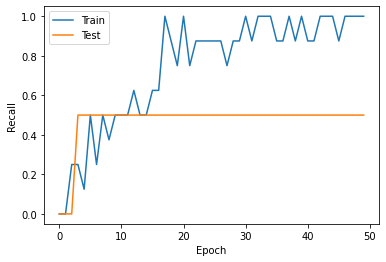

In [81]:
import matplotlib.pyplot as plt

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.plot(hist['epoch'], hist['recall_0'], label='Train')
    plt.plot(hist['epoch'], hist['val_recall_0'], label = 'Test')
    plt.legend()

plot_history(history)